# L1 norm prior experiment

This code attempts to learn the 2D prior
$J(x) = ||x||_1$
assuming we have access to training data $\{y_i, S(y_i)\}$, $S(y_i)$- using Huber function 

## Import modules 

In [1]:
import os
import numpy as np
import torch

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import seaborn as sns

from network import LPN
from lib.utils import cvx
from lib.invert import invert

# set location
MODEL_DIR = "experiments/models/L1_prior_2D"
os.makedirs(MODEL_DIR, exist_ok=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# set random seeds
np.random.seed(1)
torch.manual_seed(1)

# plotting options
plt.rcParams.update({"text.usetex": False})
sns.set_theme()

# Utility functions and plotting tools

In [2]:
##############################
#----- Utlity functions -----#
##############################

# Elementary functions, with the axis specified.
def euclid_norm(x):
    return np.linalg.norm(x, ord = 2, axis = 1)


def inner_prod(x,y):
    return np.sum(x*y, axis = 1)

def euclid_norm_sq(x):
    if x.ndim == 1:
        return np.sum(x*x)
    return np.sum(x * x, axis=1)


def exp_func(x, gamma):
    ''' Proximal matching loss -- x |-> 1 - exp(-(||x||_{2}^{2}/gamma)^{2})
        for training learned proximal networks.
    '''
    return -torch.exp(-((torch.linalg.vector_norm(x, ord = 2, dim = 1)/ gamma) ** 2)) + 1.0


def hjsol_true(y,t=1.0):
    # Section 3.1: Convex Prior J(x) = ||x||_1
    # S(x,t) is the Moreau Envelope of the L1 norm (Huber function).
    # Per component j: if |x_j| > t: |x_j| - t/2. If |x_j| <= t: x_j^2 / 2t
    
    abs_y = np.abs(y)
    # Mask for |x| <= t
    small_mask = abs_y <= t
    
    # Component-wise values
    comps = np.zeros_like(y)
    comps[small_mask] = (abs_y[small_mask]**2) / (2 * t)
    comps[~small_mask] = abs_y[~small_mask] - (t / 2.0)
    
    # Sum across dimensions (separable)
    return np.sum(comps, axis=1)


def prior_true(y):
    # J(x) = ||x||_1
    return np.sum(np.abs(y), axis=1)


def cvx_true(y,t=1.0):
    '''
    Computes Psi(y) = 0.5*||y||^2 - S(y,t).
    The target convex function to learn.
    '''
    return 0.5 * euclid_norm_sq(y) - hjsol_true(y, t)


def invert_prior(x, model, INVERT_MODE):
    ''' This function inverts the learned prior at a set of query points x.
    That is, we compute the points y for which nabla_{y}psi(y) = x, 
    where nabla_{y}*psi denotes the gradient of the LPN network.

        Args:
            x:              A numpy array of real numbers at which to invert the prior.
            model:          The trained LPN model object.
            INVERT_MODE:    The method for inverting the LPN network.

        Returns:    y:      The (approximate) set of points for which nabla_{y}psi(y) = x,
                            as a numpy array.
    '''

    y = invert(x,model,INVERT_MODE)
    return y


def evaluate_learned_prior(x, y, model, INVERT_MODE):
    ''' This function evaluates the learned prior at the points y obtained from
    inverting the prior, that is, for which nabla_{y}psi(y) = x, where nabla_{y}psi denotes
    the gradient of the LPN network.
    
    Args:
            x:              A numpy array of real numbers at which to invert the prior.
            model:          The trained LPN model object.
            INVERT_MODE:    The method for inverting the LPN network.

    Returns:    prior_est   The learned initial data (prior) of the HJ PDE at the points x.
    '''

    psi = model.scalar(torch.tensor(y).float().to(device)).squeeze(1).detach().cpu().numpy()
    prior_est = np.sum(x*y, axis = 1) - 0.5 * euclid_norm(x) - psi

    return prior_est

############################
#----- Plotting tools -----#
############################

def compute_square_cross_sections(a, spacing, dim):
    ''' Compute the cross sections (xi,0,...,0) and (0,xi,0,...,0) 
    on the grid [-a,a]^{dim} along the first and second dimensions.

    Args:       a:      A positive number
                spacing: Number of grid spacing along [-a,a]
                dim:    Dimension of the Hamilton--Jacobi PDE

    Returns:    xi:             The numpy array np.linspace(-a, a, spacing)

                x1_0_points:    k x dim numpy array of points, where
                                x_1_0_points[:,0] = np.linspace(-a, a, spacing)
                                with the rest of the entries equal to 0, and
                                k = xi.size

                x2_0_points:    k x dim numpy array of points, where
                                x_2_0_points[:,1] = np.linspace(-a, a, spacing)
                                with the rest of the entries equal to 0, and
                                k = xi.size
    '''

    xi = np.linspace(-a,a,spacing)
    grid = np.zeros((xi.size, dim))
    x1_0_points = np.copy(grid); x1_0_points[:,0] = xi
    x2_0_points = np.copy(grid); x2_0_points[:,1] = xi

    return xi, x1_0_points, x2_0_points


def cross_sections_plots(model,a,spacing,INVERT_MODE,dim):
    ''' Compare the true solution of the Hamilton--Jacobi PDE vs the LPN model
        on a square grid [-a,a]^{dim} by overlaying their cross sections along the first and second axes.

    Args:
            model:          The trained LPN model object.
            a:              Measure of the grid [-a,a]^{dim}
            spacing:        Number of points in the interval [-a,a]
            mu1, mu2:       n-dimensional numpy arrays for specifying the initial data
            sigma1, sigma2: Positive numbers for specifying the initial data
            INVERT_MODE:    The method for inverting the LPN network.
            dim:            Spatial dimension of the problem
    '''

    # Compute the cross sections in the first and second axes of the grid [-a,a]^{dim}. 
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)

    # Compute the true initial data and convex functions at the cross section points
    x1_0_cvx_true = cvx_true(x1_0_points,t=1.0) 
    x2_0_cvx_true = cvx_true(x2_0_points,t=1.0)

    x1_0_prior_true = prior_true(x1_0_points)
    x2_0_prior_true = prior_true(x2_0_points)

    # Compute the learned initial data and convex functions at the cross section points
    x1_0_cvx_est = cvx(x1_0_points,model)
    x2_0_cvx_est = cvx(x2_0_points,model)
    
    y1 = invert(x1_0_points,model,INVERT_MODE)
    y2 = invert(x2_0_points,model,INVERT_MODE)
    x1_0_prior_est = evaluate_learned_prior(x1_0_points, y1, model, INVERT_MODE)
    x2_0_prior_est = evaluate_learned_prior(x2_0_points, y2, model, INVERT_MODE)

    # Plot cross sections of the convex function
    plt.figure(figsize=(12,5))
    
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_cvx_est, "-", label="LPN")
    plt.plot(xi, x1_0_cvx_true, "--", label="Ref")
    plt.grid(True)
    plt.title(f"Cross sections ($x_1$,0) of the convex function, Dim {dim}",fontsize=16)
    plt.xlabel('$x_1$',fontsize=16)
    plt.ylabel('Convex functions $(x_1,0,...)$',fontsize=16)
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_cvx_est, "-", label="LPN")
        plt.plot(xi, x2_0_cvx_true, "--", label="Ref")
        plt.grid(True)
        plt.title(f"Cross sections ($0,x_2$,0) of the convex function, Dim {dim}",fontsize=16)
        plt.xlabel('$x_2$',fontsize=16)
        plt.ylabel('Convex functions $(0,x_2,0,...)$',fontsize=16)
        plt.legend()
    plt.tight_layout()
    

    plt.figure(figsize=(12,5))
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_prior_est, "-",label="LPN")
    plt.plot(xi, x1_0_prior_true, "-",label="Ref")
    plt.grid(True)
    plt.title(f"Cross sections ($x_1$,0) of the prior function,Dim {dim}",fontsize=16)
    plt.xlabel('$x_1$',fontsize=16)
    plt.ylabel('Prior functions ($x_1$,0)',fontsize=16)
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_prior_est, "-", label="LPN")
        plt.plot(xi, x2_0_prior_true, "-", label="Ref")
        plt.grid("on")
        plt.title(f"Cross sections ($0,x_2$,0) of the prior function,Dim {dim}",fontsize=16)
        plt.xlabel('$x_1$',fontsize=16)
        plt.ylabel('Prior functions ($0,x_2$,0)',fontsize=16)
        plt.legend()
    plt.tight_layout()

def plot_all(model,a,spacing,INVERT_MODE,dim):

    # Plot cross sections of the HJ PDEs vs learned proximal network along the first and second dimensions.
    cross_sections_plots(model,a,spacing,INVERT_MODE,dim)

## Parameters

In [3]:
# Dimension
dim = 2

# Define the spatial grid [-a,a]^{dim}
a, spacing = 4, 100

# Number of samples from the solution we have access to
data_points = 20000
Iterations = 500000

# LPN model parameters
beta = 5       # beta of softplus
hidden = 256     # number of hidden units
layers = 2      # number of layers

# optimization algorithm to use for computing the prior (cvx_cg, cvx_gd)
INVERT_MODE = "cvx_gd"

## Generate training data

In [4]:
# Generate samples {yi} uniformly in the grid [-a,a]^{dim}
input = np.zeros((dim,data_points))

if(dim>1):
    for k in range(0,dim):
        input[k] = np.random.uniform(-a,a,data_points)
else:
    input = np.random.uniform(-a,a,data_points)

input = input.reshape(data_points,dim)

# Generate the samples
cvx_samples = cvx_true(input,t=1.0).reshape(data_points,-1)

# Recast the samples as tensors
input = torch.from_numpy(input).float()
cvx_samples = torch.from_numpy(cvx_samples).float()

# --- ADD THIS TO MOVE DATA TO GPU ---
input = input.to(device)
cvx_samples = cvx_samples.to(device)

## Training function

In [5]:
def single_iteration(i, data_points, lpn_model, optimizer, input,cvx_samples,loss_type, gamma_loss=None):
    # Compute the convex function from the input.
    cvx_out = lpn_model.scalar(input)

    # Calculate the loss function
    if loss_type == 2:
        loss = (cvx_out - cvx_samples).pow(2).sum() / data_points   # MSE loss
    elif loss_type == 1:
        loss = (cvx_out - cvx_samples).abs().sum() / data_points    # MAE loss
    elif loss_type == 0:
        loss = exp_func(cvx_out - cvx_samples, gamma_loss).mean()   # proximal matching loss
    else:
        raise ValueError("loss_type must be 0, 1, or 2")


    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    lpn_model.wclip()

    # monitor
    # loss_lstar = exp_func(out - target, 0.1).mean()

    if not i % 5000:
        print("iteration", i, "loss", loss.item()) #, "loss_lstar", loss_lstar.item())

# Train

L2 loss -- Train

In [6]:
# initialize
lpn_model = LPN(in_dim=dim, hidden=hidden, layers=layers, beta=beta).to(device)
optimizer = torch.optim.Adam(lpn_model.parameters(), lr=1e-3)

for i in range(1):
    single_iteration(i, data_points, lpn_model, optimizer,input,cvx_samples,loss_type=2)

for g in optimizer.param_groups:
    g["lr"] = 1e-3
for i in range(Iterations):
    if (i % 100000 == 0) and (i > 0): 
        for g in optimizer.param_groups:
            new_lr = g["lr"] * 1e-1
            g["lr"] = new_lr
        print(f"Learning rate decreased to {new_lr} at iteration {i}")
    single_iteration(i, data_points, lpn_model, optimizer,input,cvx_samples,loss_type=2)


# save the model
torch.save(lpn_model.state_dict(), os.path.join(MODEL_DIR, "l2.pth"))

iteration 0 loss 6.663645267486572
iteration 0 loss 1573.0255126953125


iteration 5000 loss 0.003792384173721075


iteration 10000 loss 0.0008183295140042901


iteration 15000 loss 0.0005231510731391609


iteration 20000 loss 0.00033790493034757674


iteration 25000 loss 0.0002803704119287431


iteration 30000 loss 0.0002288603427587077


iteration 35000 loss 0.00028648742591030896


iteration 40000 loss 0.00018618088506627828


iteration 45000 loss 0.00016094755847007036


iteration 50000 loss 0.00014397977793123573


iteration 55000 loss 0.00013240570842754096


iteration 60000 loss 0.00014577967522200197


iteration 65000 loss 0.00011034259659936652


iteration 70000 loss 0.00010512305016163737


iteration 75000 loss 9.455237159272656e-05


iteration 80000 loss 8.942403655964881e-05


iteration 85000 loss 8.542618161300197e-05


iteration 90000 loss 8.04204901214689e-05


iteration 95000 loss 7.412250124616548e-05


Learning rate decreased to 0.0001 at iteration 100000
iteration 100000 loss 6.665553519269451e-05


iteration 105000 loss 6.159163604024798e-05


iteration 110000 loss 5.6493579904781654e-05


iteration 115000 loss 5.238991798250936e-05


iteration 120000 loss 4.888492185273208e-05


iteration 125000 loss 4.5518725528381765e-05


iteration 130000 loss 4.2998111894121394e-05


iteration 135000 loss 4.0711525798542425e-05


iteration 140000 loss 3.8395020965253934e-05


iteration 145000 loss 3.670465594041161e-05


iteration 150000 loss 3.5024706448893994e-05


iteration 155000 loss 3.346093581058085e-05


iteration 160000 loss 3.2181484129978344e-05


iteration 165000 loss 3.091636244789697e-05


iteration 170000 loss 2.9779075703117996e-05


iteration 175000 loss 2.8797130653401837e-05


iteration 180000 loss 2.7734069590223953e-05


iteration 185000 loss 2.6780271582538262e-05


iteration 190000 loss 2.5911458578775637e-05


iteration 195000 loss 2.5106572138611227e-05


Learning rate decreased to 1e-05 at iteration 200000
iteration 200000 loss 2.4378852685913444e-05


iteration 205000 loss 2.4124670744640753e-05


iteration 210000 loss 2.337464684387669e-05


iteration 215000 loss 2.2640298993792385e-05


iteration 220000 loss 2.1963858671369962e-05


iteration 225000 loss 2.1353529518819414e-05


iteration 230000 loss 2.07673292607069e-05


iteration 235000 loss 2.0252688045729883e-05


iteration 240000 loss 1.9730490748770535e-05


iteration 245000 loss 1.9273540601716377e-05


iteration 250000 loss 1.879930823633913e-05


iteration 255000 loss 1.8369151803199202e-05


iteration 260000 loss 1.7959757315111347e-05


iteration 265000 loss 1.75603709067218e-05


iteration 270000 loss 1.719526517263148e-05


iteration 275000 loss 1.6851856344146654e-05


iteration 280000 loss 1.6513504306203686e-05


iteration 285000 loss 1.6184734704438597e-05


iteration 290000 loss 1.5858066035434604e-05


iteration 295000 loss 1.5547337170573883e-05


Learning rate decreased to 1.0000000000000002e-06 at iteration 300000
iteration 300000 loss 1.5241631444951054e-05


iteration 305000 loss 1.5066769265104085e-05


iteration 310000 loss 1.480102764617186e-05


iteration 315000 loss 1.454520952393068e-05


iteration 320000 loss 1.4298806490842253e-05


iteration 325000 loss 1.4064556125958916e-05


iteration 330000 loss 1.3841134204994887e-05


iteration 335000 loss 1.3621711332234554e-05


iteration 340000 loss 1.3405441677605268e-05


iteration 345000 loss 1.3203199159761425e-05


iteration 350000 loss 1.3002319064980838e-05


iteration 355000 loss 1.2810218322556466e-05


iteration 360000 loss 1.2619831977644935e-05


iteration 365000 loss 1.243583028553985e-05


iteration 370000 loss 1.2251544831087813e-05


iteration 375000 loss 1.2082550711056683e-05


iteration 380000 loss 1.1915287359443028e-05


iteration 385000 loss 1.1757804713852238e-05


iteration 390000 loss 1.1596084732445888e-05


iteration 395000 loss 1.1435317901486997e-05


Learning rate decreased to 1.0000000000000002e-07 at iteration 400000
iteration 400000 loss 1.1288692803645972e-05


iteration 405000 loss 1.1254555829509627e-05


iteration 410000 loss 1.119924672821071e-05


iteration 415000 loss 1.1146867109346204e-05


iteration 420000 loss 1.1096186426584609e-05


iteration 425000 loss 1.1046574400097597e-05


iteration 430000 loss 1.099789824365871e-05


iteration 435000 loss 1.094998970074812e-05


iteration 440000 loss 1.0902672329393681e-05


iteration 445000 loss 1.0856098015210591e-05


iteration 450000 loss 1.0810016647155862e-05


iteration 455000 loss 1.076451826520497e-05


iteration 460000 loss 1.0719727470132057e-05


iteration 465000 loss 1.0675487828848418e-05


iteration 470000 loss 1.0631672012095805e-05


iteration 475000 loss 1.0588364602881484e-05


iteration 480000 loss 1.0545633813308086e-05


iteration 485000 loss 1.0503345947654452e-05


iteration 490000 loss 1.0461427336849738e-05


iteration 495000 loss 1.0419806130812503e-05


L2 loss -- Plot

loss -0.17779773473739624


loss -101.16874694824219


loss -201.725830078125


loss -285.96380615234375


loss -343.8467712402344


loss -386.322509765625


loss -416.8429870605469


loss -438.4571533203125


loss -453.15606689453125


loss -462.68865966796875


loss -468.567138671875


loss -472.2001953125


loss -474.60516357421875


loss -476.34918212890625


loss -477.7216796875


loss -478.8749084472656


loss -479.8915710449219


loss -480.81378173828125


loss -481.6585693359375


loss -482.4291076660156


loss -483.1235046386719


loss -483.7393798828125


loss -484.2762756347656


loss -484.7361755371094


loss -485.1243896484375


loss -485.4488525390625


loss -485.7186279296875


loss -485.9418029785156


loss -486.125244140625


loss -486.27520751953125


loss -486.3976135253906


loss -486.49810791015625


loss -486.58123779296875


loss -486.65081787109375


loss -486.70947265625


loss -486.75909423828125


loss -486.80126953125


loss -486.8370361328125


loss -486.86749267578125


loss -486.8935546875


final mse:  1.445411817257991e-05
max, min: 15.413577 -10.123366
loss -0.17779773473739624


loss -101.1509017944336


loss -201.60308837890625


loss -286.06591796875


loss -343.87744140625


loss -386.34649658203125


loss -416.8843994140625


loss -438.4598083496094


loss -453.113037109375


loss -462.689453125


loss -468.57330322265625


loss -472.1614990234375


loss -474.5314025878906


loss -476.248779296875


loss -477.57135009765625


loss -478.62811279296875


loss -479.4990234375


loss -480.24029541015625


loss -480.8923034667969


loss -481.482177734375


loss -482.0260925292969


loss -482.5313415527344


loss -482.998779296875


loss -483.42547607421875


loss -483.8070983886719


loss -484.14031982421875


loss -484.424560546875


loss -484.66241455078125


loss -484.85931396484375


loss -485.0221252441406


loss -485.1578674316406


loss -485.272705078125


loss -485.37152099609375


loss -485.4582214355469


loss -485.5357360839844


loss -485.6064453125


loss -485.6719665527344


loss -485.7333984375


loss -485.7914733886719


loss -485.8465576171875


final mse:  4.617959712049924e-05
max, min: 15.776382 -11.899744


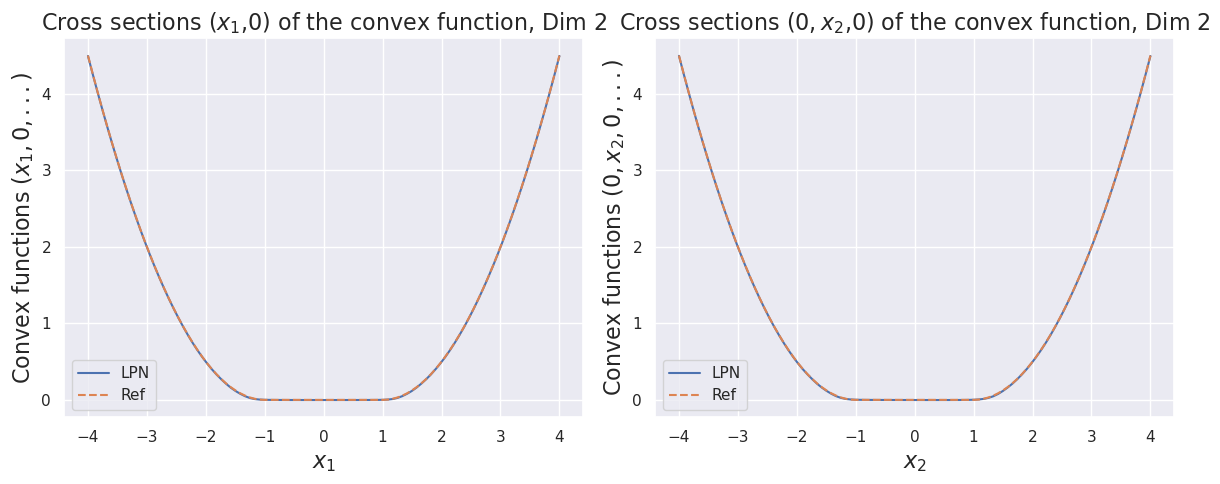

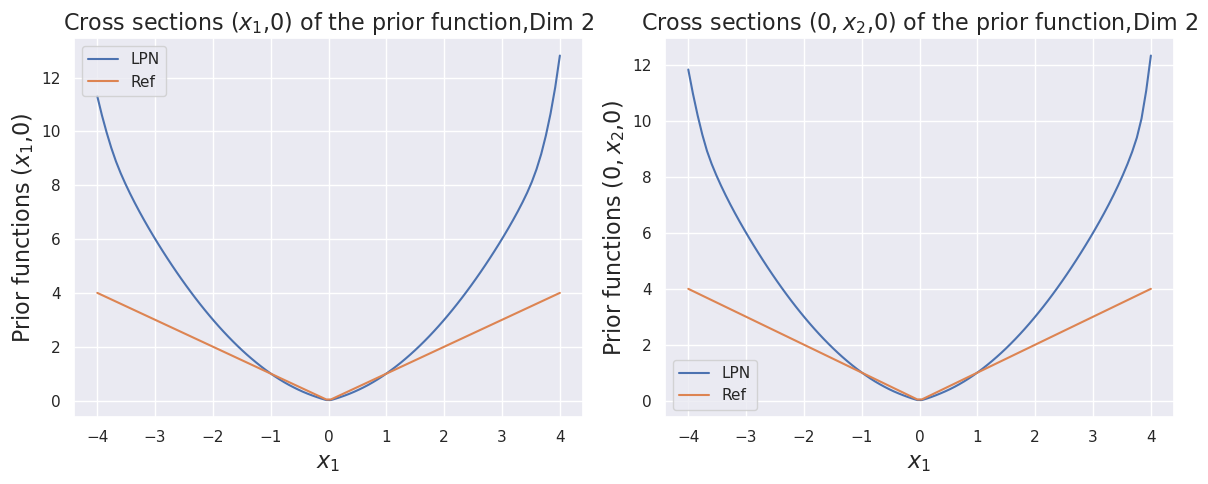

In [7]:
plot_all(lpn_model,a,spacing,INVERT_MODE,dim)

In [8]:
# --- Generate New Training Data for the Second LPN G(x) ---
# We use the same x_j_exp_tensor as the first LPN's training data for x_k
x_k_tensor = input.clone().to(device)
x_k_tensor.requires_grad_(True)

# Compute the gradient y_k = grad_x psi_theta(x_k, t=1)
# Get psi(x_k)
psi_x_k = lpn_model.scalar(x_k_tensor)

# Get gradient y_k = grad_psi(x_k)
y_k_tensor = lpn_model(x_k_tensor)

# Evaluate the "new" samples G_k = <y_k, x_k> - psi_theta(x_k, 1) (from eq 26)
inner_prod_yk_xk = torch.sum(y_k_tensor * x_k_tensor, dim=1, keepdim=True)
G_samples_tensor_with_graph = inner_prod_yk_xk - psi_x_k

G_samples_tensor = G_samples_tensor_with_graph.detach().to(device)

x_k_tensor = x_k_tensor.detach()
x_k_tensor.requires_grad_(False) 
y_k_tensor = y_k_tensor.detach()
y_k_tensor.requires_grad_(False)

# --- Train 2nd LPN ---
print("\n--- Training Second LPN G(x) for Concave Quadratic Prior ---")
lpn_model_G = LPN(in_dim=dim, hidden=hidden, layers=layers, beta=beta, eps=1e-3).to(device)
optimizer_G = torch.optim.Adam(lpn_model_G.parameters(), lr=1e-3)

# Initial shorter training phase
for i in range(1):
     single_iteration(i, data_points, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=2, gamma_loss=None)

for g in optimizer_G.param_groups:
    g["lr"] = 1e-3 
for i in range(Iterations):
    if (i % 100000 == 0) and (i > 0): 
        for g in optimizer_G.param_groups:
            new_lr = g["lr"] * 1e-1
            g["lr"] = new_lr
        print(f"Learning rate decreased to {new_lr} at iteration {i}")    
    single_iteration(i, data_points, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=2, gamma_loss=None)

torch.save(lpn_model_G.state_dict(), os.path.join(MODEL_DIR, "G_network_l2.pth"))
print("Training of 2nd LPN complete and model saved.")


--- Training Second LPN G(x) for Concave Quadratic Prior ---
iteration 0 loss 30.842287063598633
iteration 0 loss 433.1614990234375


iteration 5000 loss 0.003712008474394679


iteration 10000 loss 0.0016315686516463757


iteration 15000 loss 0.0010438335593789816


iteration 20000 loss 0.000864133529830724


iteration 25000 loss 0.0007527647539973259


iteration 30000 loss 0.0006796611123718321


iteration 35000 loss 0.0006064298213459551


iteration 40000 loss 0.0005797076155431569


iteration 45000 loss 0.0005271742702461779


iteration 50000 loss 0.0005112622166052461


iteration 55000 loss 0.00045348305138759315


iteration 60000 loss 0.00045371364103630185


iteration 65000 loss 0.0003805962041951716


iteration 70000 loss 0.0003601605712901801


iteration 75000 loss 0.00030852598138153553


iteration 80000 loss 0.0023804418742656708


iteration 85000 loss 0.000276909617241472


iteration 90000 loss 0.00024674777523614466


iteration 95000 loss 0.0002413424663245678


Learning rate decreased to 0.0001 at iteration 100000
iteration 100000 loss 0.0002227273944299668


iteration 105000 loss 0.0002088184264721349


iteration 110000 loss 0.00019057755707763135


iteration 115000 loss 0.0001761697349138558


iteration 120000 loss 0.0001645015290705487


iteration 125000 loss 0.00015445094322785735


iteration 130000 loss 0.00014651975652668625


iteration 135000 loss 0.00013965298421680927


iteration 140000 loss 0.00013303279411047697


iteration 145000 loss 0.00012677436461672187


iteration 150000 loss 0.00012184898514533415


iteration 155000 loss 0.00011710796388797462


iteration 160000 loss 0.00011237866419833153


iteration 165000 loss 0.00010795061098178849


iteration 170000 loss 0.00010432596172904596


iteration 175000 loss 0.00010067577386507764


iteration 180000 loss 9.711198799777776e-05


iteration 185000 loss 9.378154209116474e-05


iteration 190000 loss 9.0604109573178e-05


iteration 195000 loss 8.86646521394141e-05


Learning rate decreased to 1e-05 at iteration 200000
iteration 200000 loss 8.470155444229022e-05


iteration 205000 loss 8.286851516459137e-05


iteration 210000 loss 8.01934365881607e-05


iteration 215000 loss 7.759195432299748e-05


iteration 220000 loss 7.508623093599454e-05


iteration 225000 loss 7.28786617401056e-05


iteration 230000 loss 7.066773105179891e-05


iteration 235000 loss 6.85892955516465e-05


iteration 240000 loss 6.663441308774054e-05


iteration 245000 loss 6.484334880951792e-05


iteration 250000 loss 6.304059934336692e-05


iteration 255000 loss 6.112967821536586e-05


iteration 260000 loss 5.962076465948485e-05


iteration 265000 loss 5.8034787798533216e-05


iteration 270000 loss 5.6467459216946736e-05


iteration 275000 loss 5.700609472114593e-05


iteration 280000 loss 5.3641138947568834e-05


iteration 285000 loss 5.2346353186294436e-05


iteration 290000 loss 5.099832924315706e-05


iteration 295000 loss 4.974260809831321e-05


Learning rate decreased to 1.0000000000000002e-06 at iteration 300000
iteration 300000 loss 4.8538360715610906e-05


iteration 305000 loss 4.7977431677281857e-05


iteration 310000 loss 4.711928704637103e-05


iteration 315000 loss 4.6289478632388636e-05


iteration 320000 loss 4.548980723484419e-05


iteration 325000 loss 4.4710879592457786e-05


iteration 330000 loss 4.396272197482176e-05


iteration 335000 loss 4.323446046328172e-05


iteration 340000 loss 4.251468999427743e-05


iteration 345000 loss 4.179984171059914e-05


iteration 350000 loss 4.111994712729938e-05


iteration 355000 loss 4.0452927350997925e-05


iteration 360000 loss 3.979934990638867e-05


iteration 365000 loss 3.916819332516752e-05


iteration 370000 loss 3.854045644402504e-05


iteration 375000 loss 3.793009091168642e-05


iteration 380000 loss 3.73340881196782e-05


iteration 385000 loss 3.675824336824007e-05


iteration 390000 loss 3.617764014052227e-05


iteration 395000 loss 3.562685378710739e-05


Learning rate decreased to 1.0000000000000002e-07 at iteration 400000
iteration 400000 loss 3.5088000004179776e-05


iteration 405000 loss 3.501208630041219e-05


iteration 410000 loss 3.489926893962547e-05


iteration 415000 loss 3.478939470369369e-05


iteration 420000 loss 3.4682147088460624e-05


iteration 425000 loss 3.457618731772527e-05


iteration 430000 loss 3.447135168244131e-05


iteration 435000 loss 3.4367370972177014e-05


iteration 440000 loss 3.426410330575891e-05


iteration 445000 loss 3.416131585254334e-05


iteration 450000 loss 3.40590049745515e-05


iteration 455000 loss 3.3957287087105215e-05


iteration 460000 loss 3.385603486094624e-05


iteration 465000 loss 3.375517553649843e-05


iteration 470000 loss 3.3654741855571046e-05


iteration 475000 loss 3.3554897527210414e-05


iteration 480000 loss 3.345549339428544e-05


iteration 485000 loss 3.335661313030869e-05


iteration 490000 loss 3.325814759591594e-05


iteration 495000 loss 3.316038419143297e-05


Training of 2nd LPN complete and model saved.



--- Plotting Estimated Prior J(x) from 2nd LPN---


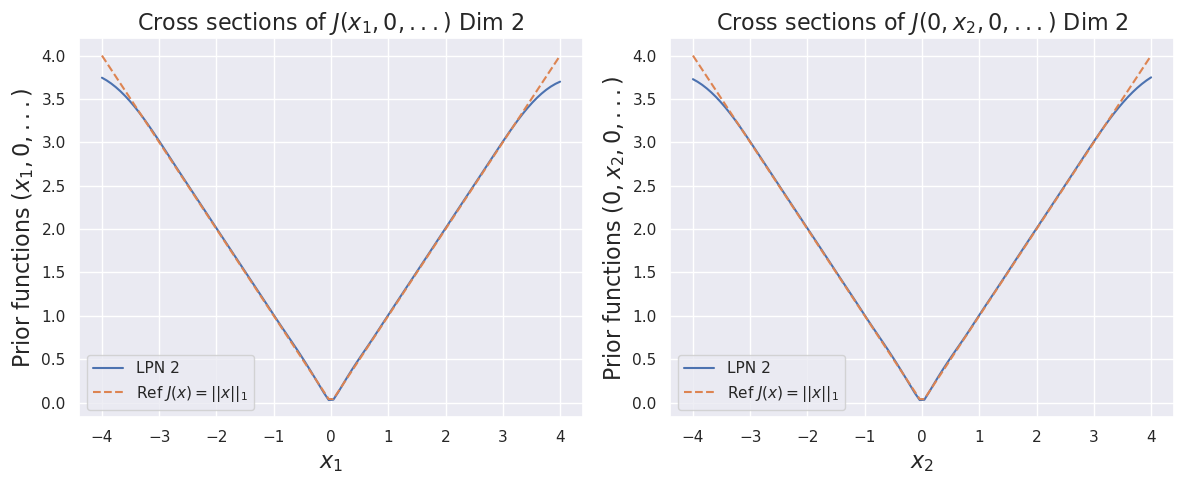

In [9]:
def evaluate_learned_J_G_network(x_points, model_G):
    """
    Evaluates the learned prior J(x) using the trained G(x) network.
    J(x) = G(x) - 0.5 * ||x||^2
    """
    # Convert to tensor
    x_tensor = torch.from_numpy(x_points).float().to(device)
    
    G_x = model_G.scalar(x_tensor)
    
    x_norm_sq_np = euclid_norm_sq(x_points)
    x_norm_sq_tensor = torch.from_numpy(x_norm_sq_np).float().to(device).reshape(-1, 1)

    J_est = G_x - 0.5 * x_norm_sq_tensor
    
    # Convert back to numpy
    J_est_np = J_est.detach().cpu().numpy().flatten()
    
    return J_est_np

def plot_J_G_network(model_G, a, spacing, dim):
    """Plots the cross-sections of the estimated prior J(x) from the G network."""
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)
    # True Prior
    x1_0_J_true = prior_true(x1_0_points)
    if dim > 1:
        x2_0_J_true = prior_true(x2_0_points)
    else:
        x2_0_J_true = x1_0_J_true
        
    x1_0_J_G_est = evaluate_learned_J_G_network(x1_0_points, model_G)
    if dim > 1:
        x2_0_J_G_est = evaluate_learned_J_G_network(x2_0_points, model_G)
    else:
        x2_0_J_G_est = x1_0_J_G_est
    
    print("\n--- Plotting Estimated Prior J(x) from 2nd LPN---")
    plt.figure(figsize=(12,5))
    
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_J_G_est, "-", label="LPN 2")
    plt.plot(xi, x1_0_J_true, "--", label="Ref $J(x)=||x||_1$")
    plt.grid(True)
    plt.title(f"Cross sections of $J(x_1,0,...)$ Dim {dim}",fontsize=16)
    plt.xlabel('$x_1$',fontsize=16)
    plt.ylabel('Prior functions $(x_1,0,...)$',fontsize=16)
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_J_G_est, "-", label="LPN 2")
        plt.plot(xi, x2_0_J_true, "--", label="Ref $J(x)=||x||_1$")
        plt.grid(True)
        plt.title(f"Cross sections of $J(0,x_2,0,...)$ Dim {dim}",fontsize=16)
        plt.xlabel('$x_2$',fontsize=16)
        plt.ylabel('Prior functions $(0,x_2,0,...)$',fontsize=16)
        plt.legend()
    plt.tight_layout()
    
# --- Execute Plotting ---
plot_J_G_network(lpn_model_G, a, spacing, dim)